<a href="https://colab.research.google.com/github/danplotkin/LSTM_Time_Series/blob/main/MultistepLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import io
import copy
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
torch.manual_seed(42)

# Load Data

In [ ]:
# Define the ticker symbol
ticker = "MSFT"

# Set the start and end dates for the data
start_date = "2000-01-01"
end_date = "2023-04-30"

# Download the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.205612,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,34.982567,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.351414,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,34.167221,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.613712,62013600


In [ ]:
df = data.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df.head(20)

,Adj Close
Date,
2000-01-03,36.205612
2000-01-04,34.982567
2000-01-05,35.351414
2000-01-06,34.167221
2000-01-07,34.613712
2000-01-10,34.866096
2000-01-11,33.973083
2000-01-12,32.866535
2000-01-13,33.487755


# Plot Adj Closing Price Over Time

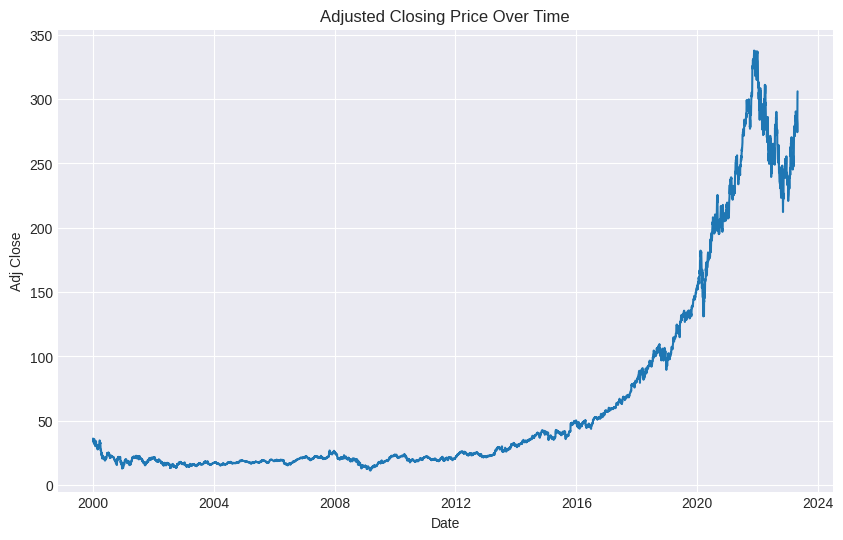

In [ ]:
plt.plot(df.index, df['Adj Close'])
plt.title('Adjusted Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

# Prepare Data

In [ ]:
def prepare_timeseries(df, window_size, look_ahead):
    df = df.copy()

    for i in reversed(range(1, window_size + 1)):
        df[f'Adj Close(t-{i})'] = df['Adj Close'].shift(i)

    for i in range(look_ahead):
        df[f'Adj Close(t+{i})'] = df['Adj Close'].shift(-i)

    return df.dropna().drop("Adj Close", axis=1)

In [ ]:
window_size = 10
look_ahead = 5
dataset = prepare_timeseries(df, window_size, look_ahead)
dataset.head()

,Adj Close(t-10),Adj Close(t-9),Adj Close(t-8),Adj Close(t-7),Adj Close(t-6),Adj Close(t-5),Adj Close(t-4),Adj Close(t-3),Adj Close(t-2),Adj Close(t-1),Adj Close(t+0),Adj Close(t+1),Adj Close(t+2),Adj Close(t+3),Adj Close(t+4)
Date,,,,,,,,,,,,,,,
2000-01-18,36.205612,34.982567,35.351414,34.167221,34.613712,34.866096,33.973083,32.866535,33.487755,34.866096,35.817356,33.235374,32.924770,32.225906,31.449373
2000-01-19,34.982567,35.351414,34.167221,34.613712,34.866096,33.973083,32.866535,33.487755,34.866096,35.817356,33.235374,32.924770,32.225906,31.449373,31.934702
2000-01-20,35.351414,34.167221,34.613712,34.866096,33.973083,32.866535,33.487755,34.866096,35.817356,33.235374,32.924770,32.225906,31.449373,31.934702,30.866970
2000-01-21,34.167221,34.613712,34.866096,33.973083,32.866535,33.487755,34.866096,35.817356,33.235374,32.924770,32.225906,31.449373,31.934702,30.866970,30.672836
2000-01-24,34.613712,34.866096,33.973083,32.866535,33.487755,34.866096,35.817356,33.235374,32.924770,32.225906,31.449373,31.934702,30.866970,30.672836,30.517530


In [ ]:
train, val = train_test_split(dataset, test_size=0.2, shuffle=False)
test = val.iloc[-1, :].values.reshape(1, -1) # get test data for test

In [ ]:
scaler = MinMaxScaler().fit(train) # fit scaler

### Create a PyTorch Dataset

In [ ]:
class MicrosoftDataset(Dataset):
    def __init__(self, dataset, scaler):
        dataset = scaler.transform(dataset)
        X, y = dataset[:, :window_size], dataset[:, window_size:]
        self.X = torch.tensor(np.expand_dims(X, axis=-1)).float()
        self.y = torch.tensor(np.expand_dims(y, axis=-1)).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# load in datasets
train_ds = MicrosoftDataset(train, scaler)
val_ds = MicrosoftDataset(val, scaler)
test_ds = MicrosoftDataset(test, scaler)

# batch into dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, shuffle=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
print(f'Train Loader Size: {len(train_loader)} \nValid Loader Size: {len(val_loader)}')

Train Loader Size: 147 
Valid Loader Size: 37


In [ ]:
for ex_in, ex_out in train_loader:
    print(ex_in.shape, ex_out.shape)
    break

torch.Size([32, 10, 1]) torch.Size([32, 5, 1])


# Define Model

In [ ]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -5:, :])
        return out

# Create Early Stopper

In [ ]:
class EarlyStopping:
    """
    Early stopping utility for monitoring validation loss during training.

    Args:
        patience (int): Number of epochs with no improvement after which training will be stopped.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        restore_best_weights (bool): Whether to restore the model to the best state when stopping.

    Attributes:
        patience (int): Number of epochs with no improvement after which training will be stopped.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        restore_best_weights (bool): Whether to restore the model to the best state when stopping.
        best_model: Copy of the model with the best validation loss.
        best_loss (float): Best validation loss observed so far.
        counter (int): Counter for the number of epochs with no improvement.
        status (str): Current status message indicating the early stopping progress.
    """

    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Check whether to stop training based on the validation loss.

        Args:
            model: The deep learning model being monitored.
            val_loss (float): Current validation loss.

        Returns:
            bool: True if training should be stopped, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

# Create Trainer

In [ ]:
class Trainer:
    """
    A class for training and evaluating a deep learning model.

    Args:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion: Loss criterion for training.
        optimizer: Optimizer for updating model parameters.
        model: The deep learning model to train and evaluate.
        device: Device on which to perform computations (e.g., 'cuda' or 'cpu').
        max_epochs (int): Maximum number of training epochs.

    Attributes:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion: Loss criterion for training.
        optimizer: Optimizer for updating model parameters.
        model: The deep learning model being trained and evaluated.
        device: Device on which computations are performed.
        early_stopper: Early stopping utility to monitor validation loss.
        max_epochs (int): Maximum number of training epochs.
        history (dict): Training and validation loss history.
        output_dir (str): Directory to save trained models.
    """

    def __init__(self,
                 train_loader,
                 val_loader,
                 criterion,
                 optimizer,
                 model,
                 device,
                 max_epochs):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.model = model
        self.device = device
        self.early_stopper = EarlyStopping(patience=10)
        self.max_epochs = max_epochs
        self.history = {}

    def _train_epoch(self):
        """
        Perform a single training epoch.

        Returns:
            float: Average training loss for the epoch.
        """
        self.model.train()
        running_loss = 0.00
        for batch_idx, (input, truth) in enumerate(self.train_loader):
            input, truth = input.to(self.device), truth.to(self.device)
            self.optimizer.zero_grad()
            pred = self.model(input)
            loss = self.criterion(pred, truth)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / len(self.train_loader)

    @torch.no_grad()
    def _eval_epoch(self):
        """
        Perform a single evaluation epoch.

        Returns:
            float: Average validation loss for the epoch.
        """
        self.model.eval()
        running_loss = 0.00
        for batch_idx, (input, truth) in enumerate(self.val_loader):
            input, truth = input.to(self.device), truth.to(self.device)
            pred = self.model(input)
            loss = self.criterion(pred, truth)
            running_loss += loss.item()
        return running_loss / len(self.val_loader)

    def train(self):
        """
        Train the model using the provided training and validation data.

        This method trains the model for the specified number of epochs,
        monitoring training and validation loss, applying early stopping,
        and adjusting the learning rate using a scheduler.
        """
        best_val_loss = np.inf
        best_epoch = 0

        train_losses, val_losses = [], []
        for epoch in range(self.max_epochs):
            tloss = self._train_epoch()
            train_losses.append(tloss)

            vloss = self._eval_epoch()
            val_losses.append(vloss)

            if (epoch + 1 == 1) or ((epoch + 1) % 5 == 0):
                print(f'Epoch {epoch+1}/{self.max_epochs}:')
                print(f'Train loss: {tloss:.4f}')
                print(f'Val loss: {vloss:.4f}')
                print()

            if vloss < best_val_loss:
                best_val_loss = vloss
                best_epoch = epoch + 1

            if self.early_stopper(self.model, vloss):
                print(f'best epoch: {best_epoch}')
                break

        print('Training Finished')

        self.history = {'train': train_losses, 'val': val_losses}

    def evaluate(self):
        """
        Evaluate the trained model on the validation dataset.

        Returns:
            float: Rounded validation loss.
        """
        vloss = self._eval_epoch()
        return np.round(vloss, 4)

# Train Model

In [ ]:
model = LSTM(
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS
).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6, weight_decay=0.01)

In [ ]:
with torch.no_grad():
    print(model(ex_in.to(DEVICE)).shape)

torch.Size([32, 5, 1])


In [ ]:
trainer = Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    model=model,
    device=DEVICE,
    max_epochs=250
)

trainer.train()

Epoch 1/250:
Train loss: 0.1191
Val loss: 5.3983

Epoch 5/250:
Train loss: 0.1032
Val loss: 5.2729

Epoch 10/250:
Train loss: 0.0860
Val loss: 5.1088

Epoch 15/250:
Train loss: 0.0707
Val loss: 4.9334

Epoch 20/250:
Train loss: 0.0571
Val loss: 4.7455

Epoch 25/250:
Train loss: 0.0468
Val loss: 4.5416

Epoch 30/250:
Train loss: 0.0403
Val loss: 4.3433

Epoch 35/250:
Train loss: 0.0372
Val loss: 4.1607

Epoch 40/250:
Train loss: 0.0358
Val loss: 4.0264

Epoch 45/250:
Train loss: 0.0348
Val loss: 3.9288

Epoch 50/250:
Train loss: 0.0341
Val loss: 3.8353

Epoch 55/250:
Train loss: 0.0334
Val loss: 3.7374

Epoch 60/250:
Train loss: 0.0327
Val loss: 3.6468

Epoch 65/250:
Train loss: 0.0319
Val loss: 3.5475

Epoch 70/250:
Train loss: 0.0312
Val loss: 3.4376

Epoch 75/250:
Train loss: 0.0301
Val loss: 3.3292

Epoch 80/250:
Train loss: 0.0292
Val loss: 3.2040

Epoch 85/250:
Train loss: 0.0281
Val loss: 3.0698

Epoch 90/250:
Train loss: 0.0272
Val loss: 2.9368

Epoch 95/250:
Train loss: 0.0262


In [ ]:
trainer.evaluate()

0.0533

# Visualize Forecast on Testing Data

In [ ]:
def tensor_to_numpy(tensor):
    return tensor.flatten().detach().cpu().numpy()


def get_real(sample_loader):
    for in_steps, out_steps in sample_loader:
        array = np.concatenate([tensor_to_numpy(in_steps),
                                tensor_to_numpy(out_steps)])
        return scaler.inverse_transform(array.reshape(1, -1)).flatten()


@torch.no_grad()
def predict(sample_loader):
    for in_steps, out_steps in sample_loader:
        in_steps = in_steps.to(DEVICE)
        output = model(in_steps)
        output = tensor_to_numpy(output)
        array = np.concatenate([tensor_to_numpy(in_steps), output])
        preds_unscaled = scaler.inverse_transform(array.reshape(1, -1))
        return preds_unscaled.flatten()

In [ ]:
truth, preds = get_real(test_loader), predict(test_loader)
time_steps = np.linspace(-window_size, look_ahead-1, look_ahead+window_size)
time_steps

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.])

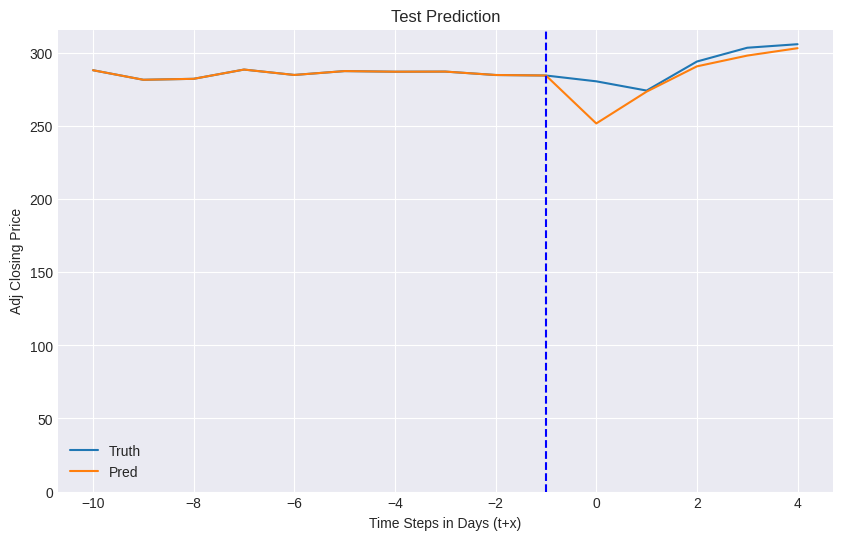

In [ ]:
plt.plot(time_steps, truth, label="Truth")
plt.plot(time_steps, preds, label="Pred")
plt.axvline(x=-1, color='blue', linestyle='--')
plt.xlabel("Time Steps in Days (t+x)")
plt.ylabel("Adj Closing Price")
plt.legend()
plt.ylim(0, np.concatenate([truth, preds]).max()+10)
plt.title("Test Prediction")

plt.show()